In [67]:
import pandas as pd
import numpy as np

df = pd.read_csv('Datasets/Credit.csv')

df.rename(columns={df.columns[-1]: 'default_status'}, inplace=True)

# Define the columns
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Method 1: Linear decay weights (most recent gets highest weight)
# Weights: [6, 5, 4, 3, 2, 1] for [AMT1, AMT2, AMT3, AMT4, AMT5, AMT6]
linear_weights = np.array([6, 5, 4, 3, 2, 1])
linear_weights = linear_weights / linear_weights.sum()  # Normalize to sum to 1

print("Linear weights:", linear_weights)

# Calculate weighted averages
df['WEIGHTED_BILL_AMT'] = np.average(df[bill_columns], weights=linear_weights, axis=1)
df['WEIGHTED_PAY_AMT'] = np.average(df[pay_columns], weights=linear_weights, axis=1)

def create_numeric_percentile_bins(df, column_name, num_bins=4):
    """
    Create percentile bins with ascending numeric codes (1, 2, 3, 4)
    """
    # Create percentile bins and assign numeric labels
    binned_column = pd.qcut(df[column_name], q=num_bins, labels=range(1, num_bins + 1), duplicates='drop')
    
    # Get the actual bin edges for reference
    _, bin_edges = pd.qcut(df[column_name], q=num_bins, retbins=True, duplicates='drop')
    
    return binned_column.astype(int), bin_edges

# Apply numeric percentile binning
variables_to_bin = ['AGE', 'LIMIT_BAL', 'WEIGHTED_BILL_AMT', 'WEIGHTED_PAY_AMT']

print("Creating numeric percentile-based bins (1=lowest quartile, 4=highest quartile)...")
print("=" * 80)

for var in variables_to_bin:
    # Create numeric bins
    binned_col, edges = create_numeric_percentile_bins(df, var, num_bins=4)
    
    # Add the binned column to dataframe
    df[f'{var}_Q'] = binned_col
    
    # Print bin information
    print(f"\n{var}_Q:")
    print(f"  Overall range: {df[var].min():.2f} to {df[var].max():.2f}")
    print(f"  Quartile boundaries and coding:")
    
    for i in range(len(edges) - 1):
        quartile_num = i + 1
        start_val = edges[i]
        end_val = edges[i + 1]
        count = (df[f'{var}_Q'] == quartile_num).sum()
        percentage = count / len(df) * 100
        
        print(f"    {quartile_num}: {start_val:8.2f} to {end_val:8.2f} | {count:,} obs ({percentage:.1f}%)")
    
    # Show the numeric distribution
    print(f"  Value counts: {dict(df[f'{var}_Q'].value_counts().sort_index())}")



df.head()



Linear weights: [0.28571429 0.23809524 0.19047619 0.14285714 0.0952381  0.04761905]
Creating numeric percentile-based bins (1=lowest quartile, 4=highest quartile)...

AGE_Q:
  Overall range: 21.00 to 79.00
  Quartile boundaries and coding:
    1:    21.00 to    28.00 | 8,013 obs (26.7%)
    2:    28.00 to    34.00 | 7,683 obs (25.6%)
    3:    34.00 to    41.00 | 6,854 obs (22.8%)
    4:    41.00 to    79.00 | 7,450 obs (24.8%)
  Value counts: {1: np.int64(8013), 2: np.int64(7683), 3: np.int64(6854), 4: np.int64(7450)}

LIMIT_BAL_Q:
  Overall range: 10000.00 to 1000000.00
  Quartile boundaries and coding:
    1: 10000.00 to 50000.00 | 7,676 obs (25.6%)
    2: 50000.00 to 140000.00 | 7,614 obs (25.4%)
    3: 140000.00 to 240000.00 | 7,643 obs (25.5%)
    4: 240000.00 to 1000000.00 | 7,067 obs (23.6%)
  Value counts: {1: np.int64(7676), 2: np.int64(7614), 3: np.int64(7643), 4: np.int64(7067)}

WEIGHTED_BILL_AMT_Q:
  Overall range: -29464.95 to 873217.38
  Quartile boundaries and coding:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_status,WEIGHTED_BILL_AMT,WEIGHTED_PAY_AMT,AGE_Q,LIMIT_BAL_Q,WEIGHTED_BILL_AMT_Q,WEIGHTED_PAY_AMT_Q
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,1,1987.809524,164.047619,1,1,1,1
1,2,120000,2,2,2,26,-1,2,0,0,...,1000,0,2000,1,2639.619048,666.666667,1,2,1,1
2,3,90000,2,2,2,34,0,0,0,0,...,1000,1000,5000,0,18487.761905,1457.523810,2,2,2,2
3,4,50000,2,2,1,37,0,0,0,0,...,1100,1069,1000,0,42508.380952,1587.285714,3,1,3,2
4,5,50000,1,2,1,57,-1,0,-1,0,...,9000,689,679,0,16363.571429,12593.428571,4,1,2,4


In [68]:
# train logistic regression model

import statsmodels.formula.api as smf
import statsmodels.api as sm 

# replace -1 with 0
df['PAY_0'] = df['PAY_0'].replace(-1, 0)

# separate between train and test

train_df = df.sample(frac=0.7, random_state=42)
test_df = df.drop(train_df.index)

train_df.shape


model = smf.glm('default_status ~ LIMIT_BAL_Q + SEX + EDUCATION + MARRIAGE + AGE_Q + PAY_0 + WEIGHTED_BILL_AMT_Q + WEIGHTED_PAY_AMT_Q', data=train_df, family=sm.families.Binomial())

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         default_status   No. Observations:                21000
Model:                            GLM   Df Residuals:                    20991
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9560.6
Date:                Sat, 21 Jun 2025   Deviance:                       19121.
Time:                        23:17:31   Pearson chi2:                 2.57e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1311
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.1974      0.134     -1.474      0.140      -0.460       0.065
LIMIT_BAL_Q            -0.1390      0.019     -7.296      0.000      -0.176      -0.102
SEX                    -0.1118      0.037     -3.014      0.003      -0.185      -0.039
EDUCATION              -0.0605      0.025     -2.415      0.016      -0.110      -0.011
MARRIAGE               -0.1505      0.039     -3.890      0.000      -0.226      -0.075
AGE_Q                   0.0377      0.018      2.105      0.035       0.003       0.073
PAY_0                   0.8464      0.021     39.870      0.000       0.805       0.888
WEIGHTED_BILL_AMT_Q    -0.0003      0.021     -0.013      0.990      -0.041       0.040
WEIGHTED_PAY_AMT_Q     -0.2598      0.022    -11.572      0.000      -0.304      -0.216
=======================================================================================
"""

Test set size: 9000
Number of actual defaults in test set: 2039
Number of predicted defaults: 738
Confusion Matrix:
[[6737  224]
 [1525  514]]

Breakdown:
True Negatives (TN): 6737
False Positives (FP): 224
False Negatives (FN): 1525
True Positives (TP): 514
=== MODEL PERFORMANCE METRICS ===
Accuracy: 0.8057 (80.57%)
Precision: 0.6965 (69.65%)
Sensitivity (Recall): 0.2521 (25.21%)
Specificity: 0.9678 (96.78%)
F1-Score: 0.3702

=== METRIC INTERPRETATIONS ===
• Accuracy: 80.6% of all predictions were correct
• Precision: 69.6% of predicted defaults were actually defaults
• Sensitivity: 25.2% of actual defaults were correctly identified
• Specificity: 96.8% of actual non-defaults were correctly identified
• F1-Score: Harmonic mean of precision and recall = 0.370
AUC-ROC Score: 0.7326


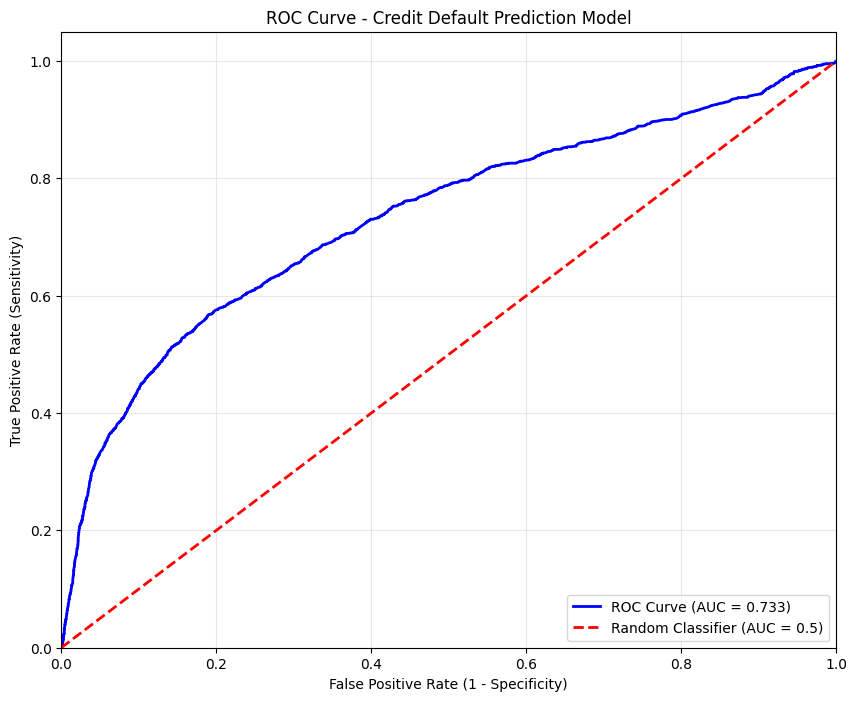


=== AUC INTERPRETATION ===
AUC = 0.733 indicates Fair discriminatory ability


In [69]:
# calculate metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


# Generate predictions on test set
# Get predicted probabilities
test_probabilities = results.predict(test_df)

# Convert probabilities to binary predictions using 0.5 threshold
test_predictions = (test_probabilities > 0.5).astype(int)

# Get actual values
test_actual = test_df['default_status'].values

print(f"Test set size: {len(test_df)}")
print(f"Number of actual defaults in test set: {sum(test_actual)}")
print(f"Number of predicted defaults: {sum(test_predictions)}")


# Calculate confusion matrix
cm = confusion_matrix(test_actual, test_predictions)
print("Confusion Matrix:")
print(cm)

# Extract components
tn, fp, fn, tp = cm.ravel()
print(f"\nBreakdown:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Calculate all performance metrics
accuracy = accuracy_score(test_actual, test_predictions)
precision = precision_score(test_actual, test_predictions)
sensitivity_recall = recall_score(test_actual, test_predictions)  # Same as sensitivity
f1 = f1_score(test_actual, test_predictions)

# Calculate specificity manually (no direct sklearn function)
specificity = tn / (tn + fp)

print("=== MODEL PERFORMANCE METRICS ===")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Sensitivity (Recall): {sensitivity_recall:.4f} ({sensitivity_recall*100:.2f}%)")
print(f"Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print(f"F1-Score: {f1:.4f}")

print("\n=== METRIC INTERPRETATIONS ===")
print(f"• Accuracy: {accuracy*100:.1f}% of all predictions were correct")
print(f"• Precision: {precision*100:.1f}% of predicted defaults were actually defaults")
print(f"• Sensitivity: {sensitivity_recall*100:.1f}% of actual defaults were correctly identified")
print(f"• Specificity: {specificity*100:.1f}% of actual non-defaults were correctly identified")
print(f"• F1-Score: Harmonic mean of precision and recall = {f1:.3f}")

# Calculate AUC
auc = roc_auc_score(test_actual, test_probabilities)
print(f"AUC-ROC Score: {auc:.4f}")

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(test_actual, test_probabilities)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - Credit Default Prediction Model')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n=== AUC INTERPRETATION ===")
if auc >= 0.9:
    interpretation = "Excellent"
elif auc >= 0.8:
    interpretation = "Good"
elif auc >= 0.7:
    interpretation = "Fair"
elif auc >= 0.6:
    interpretation = "Poor"
else:
    interpretation = "Very Poor"
    
print(f"AUC = {auc:.3f} indicates {interpretation} discriminatory ability")

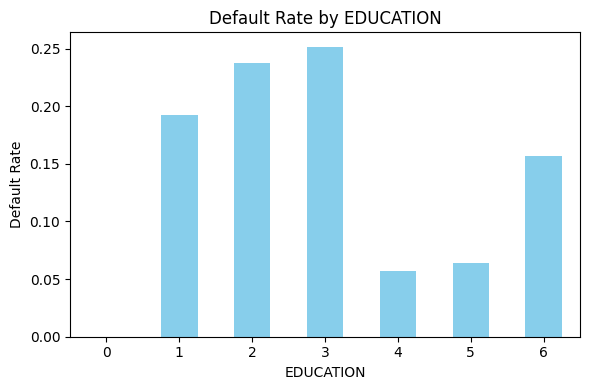

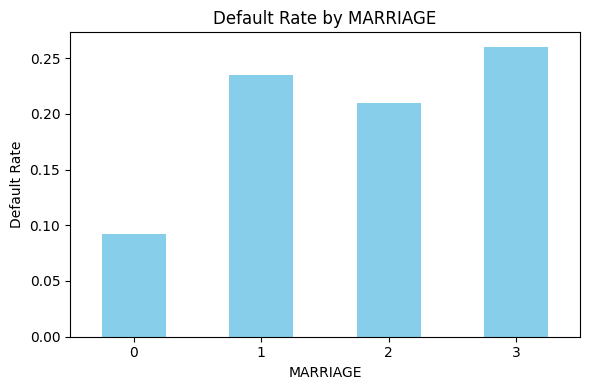

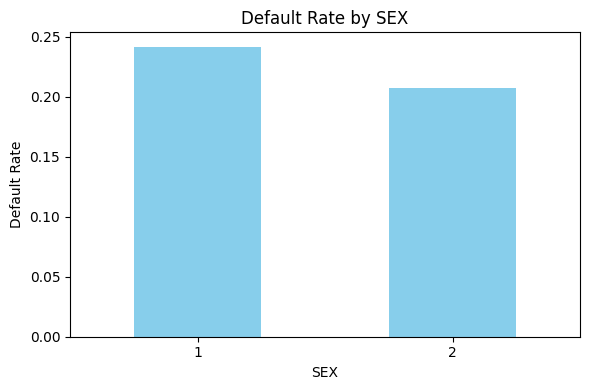

/var/folders/ck/sr6gtz6n0jx9dmp9nlplxl_w0000gn/T/ipykernel_7137/88419425.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bayes.groupby(col)['default'].mean().plot(kind='bar', color='skyblue')


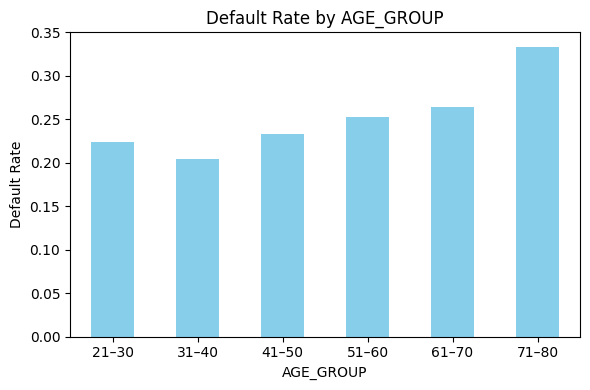


Accuracy: 0.3778888888888889

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.24      0.37      7040
           1       0.24      0.88      0.38      1960

    accuracy                           0.38      9000
   macro avg       0.56      0.56      0.38      9000
weighted avg       0.74      0.38      0.38      9000


Sample Predictions:
   Actual  Predicted Probability
0       0               0.879282
1       0               0.799860
2       0               0.852085
3       0               0.851283
4       1               0.872585
Accuracy is 0.377888 -- This means 38%  of the customers were correctly classified — either as likely to default (1) or not (0).

The report breaks down precision, recall, and F1-score for each class

For Class 0 -- No Default
Precision = 0.88: 88% of those predicted as -- No Default were correct
Recall = 0.24: 24% of the actual -- no default customers correctly predicted.
F1 = 0.37 -- Weak abilit

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Load the data
df_bayes = pd.read_csv('Datasets/Credit.csv')

# Strip any whitespace from column names
df_bayes.columns = df_bayes.columns.str.strip()

# Rename columns for clarity
df_bayes.columns = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
              'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
              'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default']

# Clean AGE column and create AGE_GROUP
df_bayes['AGE'] = pd.to_numeric(df_bayes['AGE'], errors='coerce')
df_bayes = df_bayes.dropna(subset=['AGE'])

age_bins = [20, 30, 40, 50, 60, 70, 80]
age_labels = ['21–30', '31–40', '41–50', '51–60', '61–70', '71–80']
df_bayes['AGE_GROUP'] = pd.cut(df_bayes['AGE'], bins=age_bins, labels=age_labels)

# Generating the Plot default rates
for col in ['EDUCATION', 'MARRIAGE', 'SEX', 'AGE_GROUP']:
    plt.figure(figsize=(6, 4))
    df_bayes.groupby(col)['default'].mean().plot(kind='bar', color='skyblue')
    plt.title(f'Default Rate by {col}')
    plt.ylabel('Default Rate')
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Define feature list
features = ['LIMIT_BAL', 'AGE', 'SEX', 'EDUCATION', 'MARRIAGE',
            'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Preparing features and target
X = df_bayes[features]
y = df_bayes['default']

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training Naive Bayes classifier
model = GaussianNB()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Show sample predictions
sample = pd.DataFrame({
    'Actual': y_test.values[:5],
    'Predicted Probability': y_proba[:5]
})
print("\nSample Predictions:")
print(sample)

#Printing my explanation of the result-set based on the Naive Bayes classifier

print("Accuracy is 0.377888 -- This means 38%  of the customers were correctly classified — either as likely to default (1) or not (0).")
print()
print("The report breaks down precision, recall, and F1-score for each class")
print()
print("For Class 0 -- No Default")
print("Precision = 0.88: 88% of those predicted as -- No Default were correct")
print("Recall = 0.24: 24% of the actual -- no default customers correctly predicted.")
print("F1 = 0.37 -- Weak ability to detect actual non-defaulters.")
print()
print("For Class 1 -- Default")
print("Precision = 0.24: 24% of predicted defaulters were actually defaulters")
print("Recall = 0.88: 88% of actual defaulters -- Postive case of how many prdicted to be defaulted")
print("F1 = 0.38: Weak ability to detect actual defaulter")
print(" Tha model is too conservative — reluctant to label someone as a defaulter.")
print("For credit risk, recall on Class 1 is critical — you want to catch as many defaulters as possible!")

print()
print()
print(" --- Sample Predictions ---")
print("Actual: The true class -- 0 = no default, 1 = default")
print("Predicted Probability: Model’s confidence that the customer will default")

print()

print("Row 0: True label is 0 (no default), model predicts 87% chance of default — ✅ correct and confident.")
print("Row 4: True label is 1 (default), model predicts 87% — 🟨 somewhat confident, borderline.")

print()

print(" --- Recommendations --- ")
print("Improve recall on defaulters: Try different models like (e.g., logistic regression, random forest), oversampling (SMOTE), or cost-sensitive learning.")
print("Threshold tuning: Adjust default classification threshold (not just 0.5) to balance precision/recall.") 

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score



# Define feature list
features = ['LIMIT_BAL_Q', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE_Q', 'PAY_0', 'WEIGHTED_BILL_AMT_Q', 'WEIGHTED_PAY_AMT_Q']

# Preparing features and target
X = df[features]
y = df['default_status']


# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training Naive Bayes classifier
model = GaussianNB()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Show sample predictions
sample = pd.DataFrame({
    'Actual': y_test.values[:5],
    'Predicted Probability': y_proba[:5]
})
print("\nSample Predictions:")
print(sample)

#Printing my explanation of the result-set based on the Naive Bayes classifier

print("Accuracy is 0.377888 -- This means 38%  of the customers were correctly classified — either as likely to default (1) or not (0).")
print()
print("The report breaks down precision, recall, and F1-score for each class")
print()
print("For Class 0 -- No Default")
print("Precision = 0.88: 88% of those predicted as -- No Default were correct")
print("Recall = 0.24: 24% of the actual -- no default customers correctly predicted.")
print("F1 = 0.37 -- Weak ability to detect actual non-defaulters.")
print()
print("For Class 1 -- Default")
print("Precision = 0.24: 24% of predicted defaulters were actually defaulters")
print("Recall = 0.88: 88% of actual defaulters -- Postive case of how many prdicted to be defaulted")
print("F1 = 0.38: Weak ability to detect actual defaulter")
print(" Tha model is too conservative — reluctant to label someone as a defaulter.")
print("For credit risk, recall on Class 1 is critical — you want to catch as many defaulters as possible!")

print()
print()
print(" --- Sample Predictions ---")
print("Actual: The true class -- 0 = no default, 1 = default")
print("Predicted Probability: Model’s confidence that the customer will default")

print()

print("Row 0: True label is 0 (no default), model predicts 87% chance of default — ✅ correct and confident.")
print("Row 4: True label is 1 (default), model predicts 87% — 🟨 somewhat confident, borderline.")

print()

print(" --- Recommendations --- ")
print("Improve recall on defaulters: Try different models like (e.g., logistic regression, random forest), oversampling (SMOTE), or cost-sensitive learning.")
print("Threshold tuning: Adjust default classification threshold (not just 0.5) to balance precision/recall.") 


Accuracy: 0.8107777777777778

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7040
           1       0.63      0.32      0.43      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.63      0.66      9000
weighted avg       0.79      0.81      0.79      9000


Sample Predictions:
   Actual  Predicted Probability
0       0               0.276783
1       0               0.067038
2       0               0.113744
3       0               0.148218
4       1               0.225503
Accuracy is 0.377888 -- This means 38%  of the customers were correctly classified — either as likely to default (1) or not (0).

The report breaks down precision, recall, and F1-score for each class

For Class 0 -- No Default
Precision = 0.88: 88% of those predicted as -- No Default were correct
Recall = 0.24: 24% of the actual -- no default customers correctly predicted.
F1 = 0.37 -- Weak abilit